## Imports

In [3]:
import numpy as np
import scipy as scp
import pandas as pd
#import spectrum as spec
import math
import time
from matplotlib import pyplot as plt

## Prepare raw_data.csv-File
used so for testing the data doesn't need to be fetched from grafana.

In [4]:
data_df = pd.read_csv("data/2024-03-10_testset_filtered.csv")
data_df["ticks"] = data_df["ticks"] / 1000 + time.time()
data_df["time"] = pd.to_datetime(data_df['ticks'],unit='s')
del data_df["ticks"]
# set index. important!
data_df = data_df.set_index("time")

#### add the "magnitude" columns combining x/y/z

In [3]:
data_df["xyzH"] = np.sqrt(data_df["xH"] ** 2 + data_df["yH"] ** 2 + data_df["zH"] ** 2)
data_df["xyzL"] = np.sqrt(data_df["xL"] ** 2 + data_df["yL"] ** 2 + data_df["zL"] ** 2)

#### compensate the data-aquisition-jitter (by upsampling and interpolation)

Alternative: Use nearest-neighbour or spline-interpolation instead of linear one?

In [4]:
# method=linear = ignores the index and treats them as equally spaced. not suitable for usecase, use method=time!
data_df = data_df.resample("0.001s").mean().interpolate(method='time')

# optional: downsample again to e.g. 50Hz used in HAR-Dataset?

## remove noise and split into "body" and "gravitation"-branches

In [5]:
# define butterworth filter
def bworth_filter(data, f_sample, order, f_corner, btype="low"):
    cutoff = f_corner / (0.5 * f_sample)
    b, a = scp.signal.butter(order, cutoff, btype=btype, analog=False)

    return scp.signal.filtfilt(b, a, data)

# apply filter to all columns
body_df = data_df.apply(lambda col: bworth_filter(col, 1000, 3, 20))

gravity_df = data_df.apply(lambda col: bworth_filter(col, 1000, 3, 0.3))

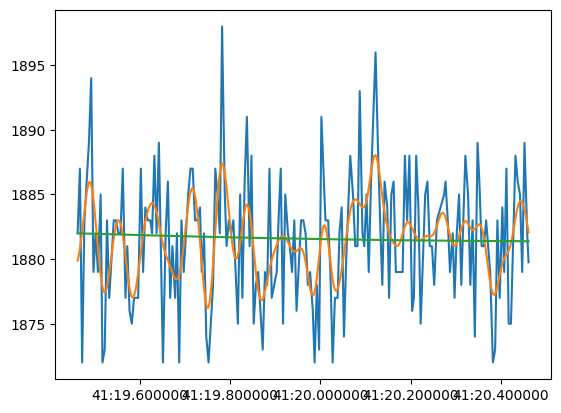

In [6]:
plt.plot(data_df.index[100:1100], data_df["xH"][100:1100])
plt.plot(body_df.index[100:1100], body_df["xH"][100:1100])
plt.plot(gravity_df.index[100:1100], gravity_df["xH"][100:1100])

In [7]:
#baseline_df = pd.merge_asof(body_df, gravity_df, left_index=True, right_index=True, direction="nearest", suffixes=("_body", "_gravity"))
baseline_df = pd.merge(body_df, gravity_df, left_index=True, right_index=True, how="outer", suffixes=("_body", "_gravity"))

In [8]:
# derivate "acceleration to jerk" 
derivative_df = baseline_df.apply(lambda col: np.gradient(col, edge_order=2))

In [9]:
intermediate_df = pd.merge(baseline_df, derivative_df, left_index=True, right_index=True, how="outer", suffixes=("_accel", "_jerk"))

## Sampling/Batching for statistical feature generation

In [10]:
## sample by time duration
TIME_DURATION = "0.5s"

intermediate_df["time_tmp"] = intermediate_df.index
intermediate_df['window_label'] = intermediate_df["time_tmp"].apply(lambda ts: ts.floor(TIME_DURATION))


In [85]:
## sample by count
BATCH_SIZE = 128
intermediate_df['window_label'] = np.arange(len(intermediate_df)) // BATCH_SIZE

### process the groups one after another

In [46]:
#intermediate_df.loc[intermediate_df["window_label"] == 1].describe()

In [53]:
output_data = []

grouped_df = intermediate_df.groupby('window_label')
for window_label, group in grouped_df:
    del group["time_tmp"]
    del group["window_label"]
    timestamps = list(group.index.map(lambda _: _.timestamp()))
    
    # add basic metrics
    v_mean = group.mean().add_suffix("_Tmean")
    v_std = group.std().add_suffix("_Tstd")
    v_mad = group.apply(lambda col: scp.stats.median_abs_deviation(col.values)).add_suffix("_Tmad")
    v_min = group.min().add_suffix("_Tmin")
    v_max = group.max().add_suffix("_Tmax")
    v_sma = group.apply(lambda col: scp.integrate.simpson(y=np.abs(col.values), x=timestamps)).add_suffix("_Tsma")
    v_iqr = group.apply(lambda col: np.subtract(*np.percentile(col.values, [75, 25]))).add_suffix("_Tiqr")
    v_entropy = group.apply(lambda col: scp.stats.entropy(col.values)).add_suffix("_Tentropy")
    v_energy = group.apply(lambda col: np.average(np.power(col.values, 2))).add_suffix("_Tenergy")


    # add AR-coefficients https://pyspectrum.readthedocs.io/en/latest/ref_param.html#spectrum.burg.arburg
    #arburg_order = 4
    #for n in range(arburg_order):
    #column_list.append()
    #arburg = group.apply(lambda col: spec.arburg(np.fabs(col.values), 4)[0]).add_suffix(f"_Tarburg_coeff")
        #column_list.append(group.apply(lambda col: spec.arburg(col.values, arburg_order)[0].real[n]).add_suffix(f"_Tar_coeff_{n}"))

    # add Frequency Space information
    #def apply_fft(col, band_count=8):
    v_fft_list = []
    fft_band_count = 8
    for col_name in group:
        col = group[col_name]
        bands_data = scp.fft.fft(col.values)
        energy_spectrum = np.abs(bands_data[:len(bands_data)//2])**2
        band_width = math.ceil(len(bands_data) / (fft_band_count * 2))
        bands_energy = {}
        for i in range(fft_band_count):
            if i == 0: # ignore the DC-Part of FFT
                s_idx = 1
            else:
                s_idx = i * band_width
            e_idx = min(len(energy_spectrum), (i+1)*band_width)
            subband_energy = np.sum(energy_spectrum[s_idx:e_idx])
            bands_energy[col.name + f"_FenergyBand_{i}"] = subband_energy
        v_fft_list.append(pd.Series(bands_energy))
    v_fft = pd.concat(v_fft_list)

    # add to the output table
    combi = pd.concat([v_mean, v_std, v_mad, v_min, v_max, v_sma, v_iqr, v_entropy, v_energy, v_fft], axis=0)
    
    output_data.append(combi)

In [54]:
output_data

[xH_body_accel_Tmean                1880.130045
 yH_body_accel_Tmean                1885.344388
 zH_body_accel_Tmean                1884.004647
 xL_body_accel_Tmean                -465.117817
 yL_body_accel_Tmean                 548.775746
                                       ...     
 xyzL_gravity_jerk_FenergyBand_3       0.000019
 xyzL_gravity_jerk_FenergyBand_4       0.000013
 xyzL_gravity_jerk_FenergyBand_5       0.000010
 xyzL_gravity_jerk_FenergyBand_6       0.000008
 xyzL_gravity_jerk_FenergyBand_7       0.000005
 Length: 680, dtype: float64,
 xH_body_accel_Tmean                1880.854269
 yH_body_accel_Tmean                1884.210768
 zH_body_accel_Tmean                1880.781258
 xL_body_accel_Tmean                -476.982843
 yL_body_accel_Tmean                 581.313564
                                       ...     
 xyzL_gravity_jerk_FenergyBand_3       0.001423
 xyzL_gravity_jerk_FenergyBand_4       0.000953
 xyzL_gravity_jerk_FenergyBand_5       0.000734
 xyzL_grav

In [75]:
spec.arburg(np.abs(group.values), 4)[0].real

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [55]:
final_data = pd.DataFrame(output_data)
final_data

,xH_body_accel_Tmean,yH_body_accel_Tmean,zH_body_accel_Tmean,xL_body_accel_Tmean,yL_body_accel_Tmean,zL_body_accel_Tmean,magni_body_accel_Tmean,temp_body_accel_Tmean,xyzH_body_accel_Tmean,xyzL_body_accel_Tmean,...,xyzH_gravity_jerk_FenergyBand_6,xyzH_gravity_jerk_FenergyBand_7,xyzL_gravity_jerk_FenergyBand_0,xyzL_gravity_jerk_FenergyBand_1,xyzL_gravity_jerk_FenergyBand_2,xyzL_gravity_jerk_FenergyBand_3,xyzL_gravity_jerk_FenergyBand_4,xyzL_gravity_jerk_FenergyBand_5,xyzL_gravity_jerk_FenergyBand_6,xyzL_gravity_jerk_FenergyBand_7
0,1880.130045,1885.344388,1884.004647,-465.117817,548.775746,10102.445560,441.195764,353.883261,3261.739071,10128.688896,...,1.041178e-08,6.539413e-09,2.608579e-03,1.053074e-04,3.574248e-05,1.918318e-05,1.282889e-05,9.885075e-06,8.479884e-06,5.326047e-06
1,1880.854269,1884.210768,1880.781258,-476.982843,581.313564,10048.586471,441.551725,301.070422,3259.645560,10077.767925,...,4.328754e-08,3.289742e-08,7.649496e-01,7.552183e-03,2.630018e-03,1.422772e-03,9.534491e-04,7.337073e-04,6.269226e-04,4.764455e-04
2,1882.021933,1884.774075,1883.174661,-500.220789,594.660033,10058.796112,443.091299,303.617985,3262.023113,10089.858472,...,1.798381e-07,1.366724e-07,3.565073e-01,3.475092e-03,1.210178e-03,6.546742e-04,4.387198e-04,3.376078e-04,2.884719e-04,2.192314e-04
3,1881.131052,1883.899226,1882.069911,-486.019018,574.011066,10033.162665,445.658633,303.124239,3260.364366,10062.299021,...,6.643609e-07,5.048978e-07,7.708949e-03,2.023666e-05,7.036172e-06,3.805079e-06,2.549587e-06,1.961866e-06,1.676286e-06,1.273921e-06
4,1881.566099,1885.374590,1884.080419,-482.293839,566.865498,10035.712942,448.539649,305.334237,3262.630260,10064.374719,...,2.846991e-06,2.163642e-06,3.767392e-02,3.243451e-04,1.129427e-04,6.109798e-05,4.094362e-05,3.150723e-05,2.692159e-05,2.045972e-05
5,1881.597929,1885.361615,1883.417639,-473.058766,568.294857,10054.768620,450.271737,302.866515,3262.257626,10082.753701,...,4.831961e-06,3.672170e-06,7.166314e-02,6.463838e-04,2.250894e-04,1.217663e-04,8.159950e-05,6.279311e-05,5.365407e-05,4.077574e-05
6,1881.486041,1884.827430,1883.519714,-522.538125,570.741033,10030.168805,451.320787,298.030564,3261.942372,10062.296119,...,2.592446e-06,1.970194e-06,1.025317e-01,9.928180e-04,3.457406e-04,1.870362e-04,1.253394e-04,9.645232e-05,8.241451e-05,6.263296e-05
7,1882.370052,1883.618779,1882.595127,-468.652214,563.840934,10029.930100,452.521168,303.986661,3261.221037,10059.222330,...,3.940166e-08,2.994413e-08,2.529524e-03,3.159666e-06,1.095308e-06,5.919431e-07,3.965335e-07,3.050917e-07,2.606666e-07,1.980938e-07
8,1880.427156,1883.855144,1882.900182,-479.628190,576.081081,10038.961333,452.780482,305.570294,3260.411980,10067.867084,...,2.214526e-06,1.682984e-06,2.753882e-01,2.746983e-03,9.566316e-04,5.175137e-04,3.468042e-04,2.668762e-04,2.280347e-04,1.733007e-04
9,1880.131298,1884.740142,1881.914137,-499.167672,580.356634,10017.791633,452.688404,298.899723,3260.182835,10048.095009,...,6.929726e-06,5.266418e-06,1.006386e+00,9.948963e-03,3.464690e-03,1.874308e-03,1.256040e-03,9.665596e-04,8.258853e-04,6.276522e-04


In [59]:
final_data.to_csv("final_data.csv")

In [27]:
group.values[0]

array([ 1.88205439e+03,  1.88400193e+03,  1.87993420e+03, -5.47095476e+02,
        4.66868136e+02,  1.00609568e+04,  4.43016838e+02,  3.38413013e+02,
        3.25971523e+03,  1.00866141e+04,  1.88210082e+03,  1.88440870e+03,
        1.88007023e+03, -5.25934864e+02,  5.10938863e+02,  1.00481763e+04,
        4.42308311e+02,  3.16646452e+02,  3.26006000e+03,  1.00755025e+04,
       -8.54442849e-02, -1.08133122e-02,  1.37319292e-01,  1.95876442e+00,
        1.95806274e+00,  1.92820867e+00, -2.42704110e-02,  1.28516070e+00,
        2.39340236e-02,  1.93850955e+00, -1.08098473e-03,  2.98752921e-04,
        2.52304719e-03,  5.28201388e-02,  8.77629764e-02,  7.33308337e-03,
       -1.63066869e-04, -1.14212929e-02,  1.01369777e-03,  9.89637682e-03])